In [315]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from PIL import Image

## 1. Загрузка данных

Загрузим данные и словарь меток классов, используя [инструкцию](https://www.cs.toronto.edu/~kriz/cifar.html).

In [316]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def row_to_image(row):
    result = np.empty((32, 32, 3), dtype='uint8')
    for i in range(3072):
        result[i % 1024 // 32][i % 1024 % 32][i // 1024] = row[i]
    return result

raw_data = [unpickle(f'./cifar-10-batches-py/data_batch_{batch}') for batch in range(1, 6)]
raw_data.append(unpickle(f'./cifar-10-batches-py/test_batch'))
all_objects = []
all_labels = []
for batch in raw_data:
    all_objects.extend(np.asarray(batch[b'data']))
    all_labels.extend(np.asarray(batch[b'labels']))

label_names = unpickle(f'./cifar-10-batches-py/batches.meta')[b'label_names']
label_names = [name.decode("utf-8") for name in label_names]

print(f'Pictures count: {len(all_objects)}')

Pictures count: 60000


Убедимся, что данные загружаются в нужном формате.

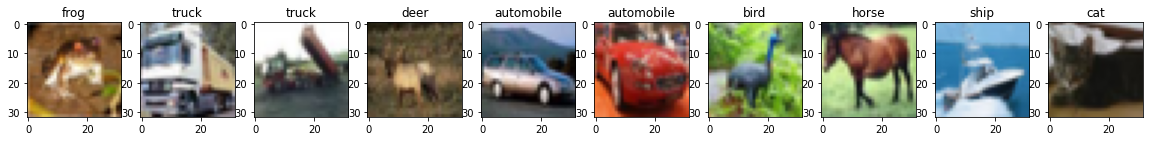

In [317]:
def draw_image(data, label, axes):
    data = row_to_image(data)
    img = Image.fromarray(data)
    axes.set_title(label)
    axes.imshow(img)

FIRST_OBJECT_TO_DRAW = 10
fig, axes = plt.subplots(1, FIRST_OBJECT_TO_DRAW, figsize=(2 * FIRST_OBJECT_TO_DRAW, 3))

for image_index in range(FIRST_OBJECT_TO_DRAW):
    draw_image(all_objects[image_index], label_names[all_labels[image_index]], axes[image_index])

Определим класс для загрузки данных и правильных ответов батчами.

In [318]:
all_objects = (np.array(all_objects) / 255).astype('float32')
x_train, x_test, y_train, y_test = train_test_split(all_objects, all_labels, test_size=0.2, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.2, random_state=0)

class DataLoader:
    """Class for loading data in batches"""

    def __init__(self, objects, labels, batch_size):
        self.objects = np.array(objects)
        self.one_hot_encoder = OneHotEncoder()
        self.labels = self.one_hot_encoder.fit_transform(np.array(labels).reshape(-1, 1)).toarray()
        self.batch_size = batch_size
        self.counter = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.counter >= len(self.objects):
            raise StopIteration

        batch = self.objects[self.counter: self.counter + self.batch_size],\
                self.labels[self.counter: self.counter + self.batch_size]
        self.counter += self.batch_size
        return batch

    def __len__(self):
        batch_amount = self.get_objects_count() // self.batch_size
        if batch_amount * self.batch_size < len(self.objects):
            batch_amount += 1
        return batch_amount

    def get_objects_count(self):
        return self.objects.shape[0]


loader = DataLoader(x_train, y_train, 3)
print(len(loader))
print(next(loader))

16000
(array([[0.05490196, 0.09803922, 0.14509805, ..., 0.19215687, 0.19607843,
        0.16470589],
       [0.6666667 , 0.59607846, 0.5529412 , ..., 0.44313726, 0.48235294,
        0.4627451 ],
       [0.65882355, 0.6431373 , 0.64705884, ..., 0.43137255, 0.3764706 ,
        0.27450982]], dtype=float32), array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]))


In [319]:
from activation_functions import tanh, tanh_d, re_lu, re_lu_d


def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1).reshape(-1, 1))
    softmax = e_x / e_x.sum(axis=1).reshape(-1, 1)
    return softmax


class NeuralNet:
    """
    Class for neural nets.
    Input layout: every row corresponds to a single batch, columns correspond to input features.
    After applying any hidden layer we get the same layout (rows are batches, columns are hidden features).
    """

    def __init__(self, input_size, hidden_size, output_size, lr):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lr = lr

        self.w_1 = np.zeros((self.input_size, self.hidden_size))
        self.b_1 = np.zeros((1, self.hidden_size))
        self.w_2 = np.zeros((self.hidden_size, self.output_size))
        self.b_2 = np.zeros((1, self.output_size))
        self.initialize_weights()

    def get_weights(self):
        return {
            'w_1': self.w_1,
            'b_1': self.b_1,
            'w_2': self.w_2,
            'b_2': self.b_2,
        }

    def set_weights(self, weights_dict):
        self.w_1 = weights_dict['w_1']
        self.b_1 = weights_dict['b_1']
        self.w_2 = weights_dict['w_2']
        self.b_2 = weights_dict['b_2']

    def initialize_weights(self):
        self.w_1 = np.random.randn(*self.w_1.shape) * np.sqrt(1. / self.hidden_size)
        self.w_2 = np.random.randn(*self.w_2.shape) * np.sqrt(1. / self.output_size)

    def forward(self, X):
        self.Z_1 = np.dot(X, self.w_1) + self.b_1
        self.A_1 = re_lu(self.Z_1)
        self.Z_2 = np.dot(self.A_1, self.w_2) + self.b_2
        self.A_2 = softmax(self.Z_2)
        return self.A_2

    def loss(self, y_pred, y_true):
        result = []
        for batch_index in range(len(y_pred)):
            y_pred_for_batch = y_pred[batch_index]
            y_true_for_batch = y_true[batch_index]
            correct_class_index = -1
            for class_index, prob in enumerate(y_true_for_batch):
                if prob == 1:
                    correct_class_index = class_index
            correct_class_pred_prob = y_pred[batch_index][correct_class_index]

            hinge_loss = sum(
                [max(0, 1 + prob - correct_class_pred_prob) for class_index, prob in enumerate(y_pred_for_batch)
                 if class_index != correct_class_index]
            )
            result.append(hinge_loss)

        return np.mean(np.array(result))

    def backward(self, X, y_pred, y_true):
        n_samples = y_true.shape[0]

        dZ_2 = []
        for batch_index in range(len(y_pred)):
            y_true_for_batch = y_true[batch_index]
            correct_class_index = -1
            for class_index, prob in enumerate(y_true_for_batch):
                if prob == 1:
                    correct_class_index = class_index
            correct_class_pred_prob = self.A_2[batch_index][correct_class_index]

            d = [self.output_size * pred * (pred - 1) if i == correct_class_index
                 else pred * (self.output_size * correct_class_pred_prob)
                 for (i, pred) in enumerate(self.A_2[batch_index])]
            dZ_2.append(d)
        dZ_2 = np.array(dZ_2)

        dw_2 = np.dot(self.A_1.T, dZ_2)
        db_2 = np.sum(dZ_2, axis=0, keepdims=True)

        dA_1 = np.dot(dZ_2, self.w_2.T)
        dZ_1 = np.multiply(dA_1, re_lu_d(self.Z_1))

        dw_1 = np.dot(X.T, dZ_1)
        db_1 = np.sum(dZ_1, axis=0, keepdims=True)

        gradient_dict = {'dw_1': dw_1 / n_samples, 'db_1': db_1 / n_samples, 'dw_2': dw_2 / n_samples,
                         'db_2': db_2 / n_samples}
        return gradient_dict

    def update_weights(self, gradient_dict):
        self.w_1 -= self.lr * gradient_dict['dw_1']
        self.b_1 -= self.lr * gradient_dict['db_1']

        self.w_2 -= self.lr * gradient_dict['dw_2']
        self.b_2 -= self.lr * gradient_dict['db_2']

## 3. Проверка корректности расчета обратного распространения ошибки

In [320]:
from utils import dict2vector, vector2dict


def gradient_check(X, y, epsilon=1e-7):
    neural_net = NeuralNet(input_size=X.shape[1],
                           hidden_size=15,
                           output_size=y.shape[1], lr=0.01)
    neural_net_params_dict = neural_net.get_weights()
    neural_net_params_vector, neural_net_params_shapes_dict = dict2vector(neural_net_params_dict)
    params_amount = neural_net_params_vector.shape[0]
    gradient_approx_vector = np.zeros((params_amount,))

    for i in range(params_amount):
        params_plus_vector = np.copy(neural_net_params_vector)
        params_plus_vector[i] += epsilon
        params_plus_dict = vector2dict(params_plus_vector, neural_net_params_shapes_dict)
        neural_net.set_weights(params_plus_dict)
        y_plus = neural_net.forward(X)
        J_plus = neural_net.loss(y_plus, y)

        params_minus_vector = np.copy(neural_net_params_vector)
        params_minus_vector[i] -= epsilon
        params_minus_dict = vector2dict(params_minus_vector, neural_net_params_shapes_dict)
        neural_net.set_weights(params_minus_dict)
        y_minus = neural_net.forward(X)
        J_minus = neural_net.loss(y_minus, y)
        gradient_approx_vector[i] = (J_plus - J_minus) / (2 * epsilon)

    neural_net.set_weights(neural_net_params_dict)
    y_pred = neural_net.forward(X)
    gradient_dict = neural_net.backward(X, y_pred, y)
    gradient_vector, _ = dict2vector(gradient_dict)

    print(np.linalg.norm(gradient_approx_vector), np.linalg.norm(gradient_vector))

    numerator = np.linalg.norm(gradient_approx_vector - gradient_vector)
    denominator = np.linalg.norm(gradient_approx_vector) + np.linalg.norm(gradient_vector)
    diff = numerator / denominator

    if diff > epsilon:
        print('Backprop is incorrect!')
    else:
        print('Backprop is correct!')
    return diff

batch_loader = DataLoader(x_train, y_train, 16)
x, y = next(batch_loader)
gradient_check(x, y, 1e-7)

4.389189918505042 4.389189907474047
Backprop is correct!


9.9339286043161e-08

In [344]:
def gradient_scale_check(X, y, lr):
    neural_net = NeuralNet(input_size=X.shape[1],
                           hidden_size=64,
                           output_size=y.shape[1], lr=lr)
    y_pred = neural_net.forward(X)
    gradient_dict = neural_net.backward(X, y_pred, y)
    param_scale = np.linalg.norm(dict2vector(model.get_weights())[0])

    weight_update = -lr * dict2vector(gradient_dict)[0]
    update_scale = np.linalg.norm(weight_update)

    scale = update_scale / param_scale

    if 1e-4 <= scale <= 1e-2:
        print('Gradient scale is correct!')
    else:
        print('Gradient scale is incorrect!')
    return scale

batch_loader = DataLoader(x_train, y_train, 16)
x, y = next(batch_loader)
gradient_scale_check(x, y, 0.05)

Gradient scale is correct!


0.00948902729061038

In [345]:
def eval_acc(y_pred, y_true):
    pred_label = np.argmax(y_pred, axis=1)
    true_label = np.argmax(y_true, axis=1)
    accuracy = (pred_label == true_label).mean()
    return accuracy


def test():
    train_dataloader = DataLoader(x_train, y_train, 4)
    data_b, target_b = next(train_dataloader)
    pred = np.random.rand(target_b.shape[0], target_b.shape[1])
    print(eval_acc(pred, target_b))


test()

0.0


## 4. Цикл обучения

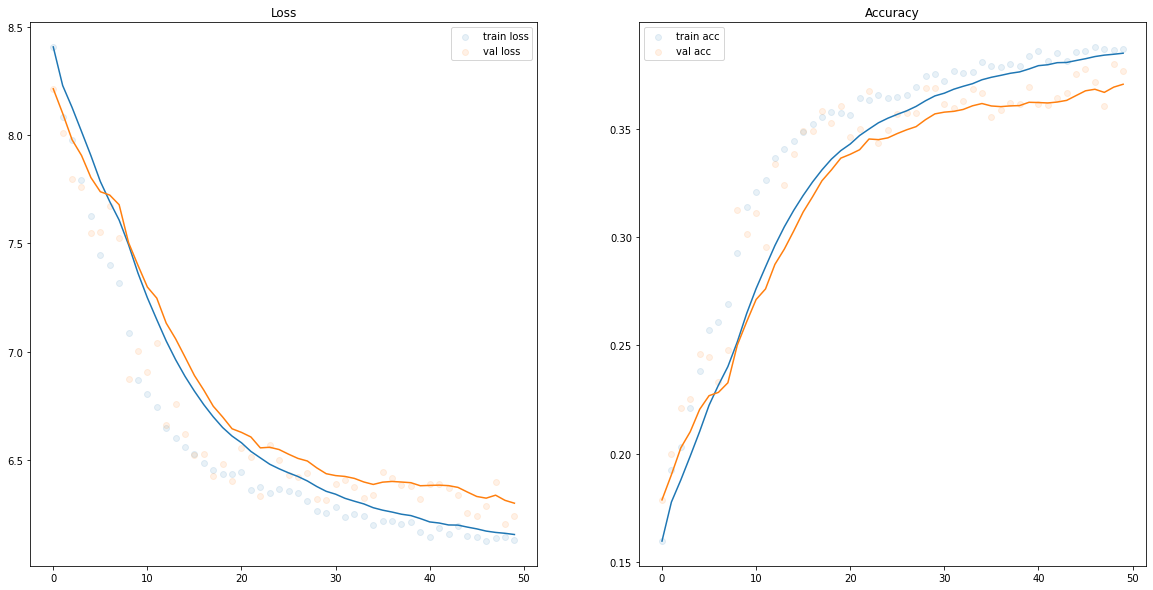

100%|██████████| 50/50 [03:26<00:00,  4.13s/it]


In [349]:
import pandas as pd
from tqdm import tqdm
from IPython.core.display_functions import clear_output
import matplotlib.pylab as plt

EPOCH_COUNT = 50
BATCH_SIZE = 100
INPUT_SIZE = 3072
HIDDEN_SIZE = 64
OUTPUT_SIZE = 10
LEARNING_RATE = 0.05

model = NeuralNet(input_size=INPUT_SIZE,
                  hidden_size=HIDDEN_SIZE,
                  output_size=OUTPUT_SIZE, lr=LEARNING_RATE)

train_epoch_loss_array, train_epoch_acc_array = [], []
val_epoch_loss_array, val_epoch_acc_array = [], []


ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values

def visualize_epoch_results(train_epoch_loss_array, val_epoch_loss_array):
    clear_output(True)
    plt.figure(figsize=[20, 10])
    plt.subplot(1, 2, 1), plt.title('Loss')
    plt.scatter(np.arange(len(train_epoch_loss_array)), train_epoch_loss_array, alpha=0.1, label='train loss')
    plt.plot(ewma(train_epoch_loss_array, span=10))
    plt.legend()
    plt.subplot(1, 2, 2), plt.title('Accuracy')
    plt.scatter(np.arange(len(train_epoch_acc_array)), train_epoch_acc_array, alpha=0.1, label='train acc')
    plt.plot(ewma(train_epoch_acc_array, span=10))
    plt.legend()
    plt.subplot(1, 2, 1)
    plt.scatter(np.arange(len(val_epoch_loss_array)), val_epoch_loss_array, alpha=0.1, label='val loss')
    plt.plot(ewma(val_epoch_loss_array, span=10))
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.scatter(np.arange(len(val_epoch_acc_array)), val_epoch_acc_array, alpha=0.1, label='val acc')
    plt.plot(ewma(val_epoch_acc_array, span=10))
    plt.legend()

    plt.show()


for epoch in tqdm(range(EPOCH_COUNT)):
    train_epoch_loss, train_epoch_acc = 0, 0
    train_dataloader = DataLoader(x_train, y_train, BATCH_SIZE)
    val_dataloader = DataLoader(x_val, y_val, BATCH_SIZE)

    for train_batch_x, train_batch_y in train_dataloader:
        train_batch_pred = model.forward(train_batch_x)
        train_batch_loss = model.loss(train_batch_pred, train_batch_y)
        gradient = model.backward(train_batch_x, train_batch_pred, train_batch_y)
        model.update_weights(gradient)

        train_epoch_loss += train_batch_loss
        train_epoch_acc += eval_acc(train_batch_pred, train_batch_y)

    train_epoch_loss_array.append(train_epoch_loss / len(train_dataloader))
    train_epoch_acc_array.append(train_epoch_acc / len(train_dataloader))

    val_epoch_loss, val_epoch_acc = 0, 0
    for x_batch, y_batch in val_dataloader:
        batch_pred = model.forward(x_batch)
        val_batch_loss = model.loss(batch_pred, y_batch)

        val_epoch_loss += val_batch_loss
        val_epoch_acc += eval_acc(batch_pred, y_batch)
    val_epoch_loss_array.append(val_epoch_loss / len(val_dataloader))
    val_epoch_acc_array.append(val_epoch_acc / len(val_dataloader))

    visualize_epoch_results(train_epoch_loss_array, val_epoch_loss_array)

## 5. Валидация

In [350]:
from sklearn.metrics import classification_report

test_dataloader = DataLoader(x_test, y_test, BATCH_SIZE)

predicted_labels = []
true_labels = []

for x_batch, y_batch in test_dataloader:
  prediction_for_batch = model.forward(x_batch)

  predicted_labels_for_batch = np.argmax(prediction_for_batch, axis=1)
  true_labels_for_batch = np.argmax(y_batch, axis=1)

  predicted_labels.append(predicted_labels_for_batch)
  true_labels.append(true_labels_for_batch)

prediction = np.concatenate(predicted_labels)
label = np.concatenate(true_labels)

result = (prediction == label).mean()

print('Accuracy: ', result)
print(classification_report(label, prediction, target_names=label_names, zero_division=0))

Accuracy:  0.36583333333333334
              precision    recall  f1-score   support

    airplane       0.34      0.63      0.44       258
  automobile       0.55      0.46      0.50       239
        bird       0.00      0.00      0.00       243
         cat       0.25      0.55      0.34       250
        deer       0.37      0.51      0.43       234
         dog       0.00      0.00      0.00       239
        frog       0.43      0.47      0.45       218
       horse       0.39      0.52      0.45       249
        ship       0.00      0.00      0.00       230
       truck       0.43      0.49      0.46       240

    accuracy                           0.37      2400
   macro avg       0.28      0.36      0.31      2400
weighted avg       0.28      0.37      0.31      2400

